<a href="https://colab.research.google.com/github/SakuniNK/AyurCare/blob/main/Copy_of_FinalTopicModelling3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y scipy gensim
!pip install scipy==1.10.1 gensim==4.3.2

Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.1 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incomp

In [ ]:
!pip install pyldavis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import glob
import re
import numpy as np
import pandas as pd
from collections import defaultdict
import spacy
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, TfidfModel, Phrases
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

# Verify installations
print(f"Gensim version: {gensim.__version__}")
print(f"SciPy version: {np.__version__}")

# Download NLP resources
nltk.download('stopwords')
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Gensim version: 4.3.2
SciPy version: 1.26.4


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Load and Preprocess Data

In [ ]:
# Step 2: Mount Drive and Import Libraries (with glob added)
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import glob  # Added missing import
import re
import numpy as np
import pandas as pd
from collections import defaultdict
import spacy
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, TfidfModel, Phrases
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

# Verify installations
print(f"Gensim version: {gensim.__version__}")
print(f"SciPy version: {np.__version__}")

# Download NLP resources
nltk.download('stopwords')
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Step 3: Load and Preprocess Data (corrected)
def load_data(directory):
    data = []
    years = []
    file_paths = glob.glob(os.path.join(directory, "*.json"))

    for file_path in file_paths:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                doc = json.load(f)
                text = ""
                # Combine sections
                for section in ["conclusion", "limitation", "future_work"]:
                    if section in doc and doc[section].strip():
                        text += doc[section] + " "
                year = doc.get("published_year", None)

                if text.strip():  # Skip empty docs
                    data.append(text.strip())
                    years.append(year)
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue

    return data, years

# Path to your JSON folder
directory_path = "/content/drive/My Drive/DsOutput"
data, years = load_data(directory_path)
print(f"Loaded {len(data)} documents")
print(f"Sample year values: {set(years[:10])}")  # Show sample years for verification

# Show sample data
print("\nSample document:")
print(data[0][:200] + "...")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Gensim version: 4.3.2
SciPy version: 1.26.4


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Loaded 423 documents
Sample year values: {2024, 2021}

Sample document:
Thinking of future generations may be an of-course-we-do-that idea, but most of
the people’s approach in this matter is limited to concerns about the future size of the
population in some places or co...


Text Preprocessing Pipeline

In [ ]:
# Custom stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {"study", "result", "paper", "research", "model", "based", "show", "use"}
stop_words.update(custom_stopwords)

def preprocess(texts):
    processed_texts = []
    for text in texts:
        # Lowercase and remove special chars/numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        # Tokenize and remove stopwords
        tokens = [word for word in simple_preprocess(text)
                 if word not in stop_words and len(word) > 2]
        processed_texts.append(tokens)
    return processed_texts

# Lemmatization
def lemmatize(texts):
    lemmatized = []
    for tokens in texts:
        doc = nlp(" ".join(tokens))
        lemmatized.append([token.lemma_ for token in doc])
    return lemmatized

# Create n-grams
def create_ngrams(texts):
    bigram = Phrases(texts, min_count=5, threshold=100)
    trigram = Phrases(bigram[texts], threshold=100)
    bigram_phraser = gensim.models.phrases.Phraser(bigram)
    trigram_phraser = gensim.models.phrases.Phraser(trigram)
    return [trigram_phraser[bigram_phraser[doc]] for doc in texts]

# Apply preprocessing
processed_data = preprocess(data)
print("Basic preprocessing completed")
lemmatized_data = lemmatize(processed_data)
print("Lemmatization completed")
ngram_data = create_ngrams(lemmatized_data)
print("N-grams created")

Basic preprocessing completed
Lemmatization completed
N-grams created


TF-IDF Filtering and Corpus Creation

In [ ]:
def filter_tfidf(ngram_data):
    id2word = corpora.Dictionary(ngram_data)
    corpus = [id2word.doc2bow(text) for text in ngram_data]

    tfidf = TfidfModel(corpus)
    filtered_corpus = []
    low_value_threshold = 0.03

    for i, bow in enumerate(corpus):
        tfidf_weights = {id: value for id, value in tfidf[bow]}
        filtered_bow = [
            (id, count) for id, count in bow
            if tfidf_weights.get(id, 0) >= low_value_threshold
        ]
        filtered_corpus.append(filtered_bow)

    return filtered_corpus, id2word

filtered_corpus, id2word = filter_tfidf(ngram_data)
print(f"Filtered corpus size: {len(filtered_corpus)}")
print(f"Dictionary size: {len(id2word)}")

Filtered corpus size: 423
Dictionary size: 63085


Train LDA Model

In [ ]:
# Train LDA model
lda_model = LdaModel(
    corpus=filtered_corpus,
    id2word=id2word,
    num_topics=50,
    random_state=100,
    passes=10,
    alpha='auto'
)

# Save model
lda_model.save("lda_model.gensim")
print("Model trained and saved")

# Show topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic #{idx}: {topic}")

Model trained and saved
Topic #0: 0.080*"climate" + 0.040*"adaptation" + 0.038*"finance" + 0.028*"change" + 0.013*"constraint" + 0.013*"mitigation" + 0.011*"country" + 0.010*"vulnerability" + 0.009*"national" + 0.009*"health"
Topic #1: 0.014*"financial" + 0.013*"level" + 0.013*"inclusive" + 0.010*"development" + 0.010*"china" + 0.010*"government" + 0.009*"regional" + 0.007*"index" + 0.007*"signal" + 0.007*"central"
Topic #2: 0.020*"public" + 0.014*"crossref" + 0.013*"wine" + 0.011*"ppp" + 0.009*"journal" + 0.009*"value" + 0.008*"debt" + 0.008*"project" + 0.007*"price" + 0.007*"reit"
Topic #3: 0.014*"increase" + 0.004*"litigation" + 0.004*"yes_yes_yes" + 0.004*"andeconomic" + 0.003*"accounting" + 0.003*"british_accounting" + 0.003*"tangibility" + 0.003*"age" + 0.003*"size" + 0.003*"profitability"
Topic #4: 0.023*"labor" + 0.022*"state" + 0.018*"econ" + 0.015*"industry" + 0.015*"marijuana" + 0.013*"capital" + 0.012*"income" + 0.012*"medical_marijuana" + 0.010*"share" + 0.010*"natural_res

Visualize Topics

In [ ]:
# Step 7: Train LDA Model and Visualize Topics (Corrected)
def visualize_topics(model, corpus, id2word):
    try:
        import pyLDAvis
        import pyLDAvis.gensim_models as gensimvis
    except ImportError:
        !pip install pyLDAvis==3.4.1
        import pyLDAvis
        import pyLDAvis.gensim_models as gensimvis

    try:
        vis = gensimvis.prepare(
            model,
            corpus,
            id2word,
            mds="mmds",
            R=30,
            sort_topics=False
        )
        return vis
    except Exception as e:
        print(f"Visualization error: {str(e)}")
        return None

# Train LDA model
num_topics = 50
lda_model = LdaModel(
    corpus=filtered_corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=100,
    passes=10,
    alpha='auto'
)

# Save model
lda_model.save("lda_model.gensim")
print("Model trained and saved\n")

# Show topics - CORRECTED VERSION
print("Discovered Topics:")
for topic_id in range(lda_model.num_topics):
    print(f"Topic #{topic_id}:")
    # Get top 10 terms with their probabilities
    top_terms = lda_model.show_topic(topic_id, topn=10)
    # Format terms with weights
    term_strings = [f"{term} ({prob:.3f})" for term, prob in top_terms]
    print(", ".join(term_strings))
    print()

# Generate visualization
vis = visualize_topics(lda_model, filtered_corpus, id2word)

if vis:
    # Display in notebook
    pyLDAvis.display(vis)
    pyLDAvis.save_html(vis, 'topic_visualization.html')
    print("Visualization saved as 'topic_visualization.html'")
else:
    print("Failed to generate visualization")

Model trained and saved

Discovered Topics:
Topic #0:
climate (0.080), adaptation (0.040), finance (0.038), change (0.028), constraint (0.013), mitigation (0.013), country (0.011), vulnerability (0.010), national (0.009), health (0.009)

Topic #1:
financial (0.014), level (0.013), inclusive (0.013), development (0.010), china (0.010), government (0.010), regional (0.009), index (0.007), signal (0.007), central (0.007)

Topic #2:
public (0.020), crossref (0.014), wine (0.013), ppp (0.011), journal (0.009), value (0.009), debt (0.008), project (0.008), price (0.007), reit (0.007)

Topic #3:
increase (0.014), litigation (0.004), yes_yes_yes (0.004), andeconomic (0.004), accounting (0.003), british_accounting (0.003), tangibility (0.003), age (0.003), size (0.003), profitability (0.003)

Topic #4:
labor (0.023), state (0.022), econ (0.018), industry (0.015), marijuana (0.015), capital (0.013), income (0.012), medical_marijuana (0.012), share (0.010), natural_resource (0.010)

Topic #5:
res

In [ ]:
# Step 1: Install Gensim and verify installation
!pip install gensim==4.3.2
import importlib

# Verify installation
gensim_spec = importlib.util.find_spec("gensim")
if gensim_spec is None:
    print("Gensim installation failed! Trying alternative method...")
    !python -m pip install --no-cache-dir gensim==4.3.2

# Now import required modules
import gensim
from gensim.models import CoherenceModel
print(f"Gensim version: {gensim.__version__}")

# Step 2: Calculate Coherence Score
def calculate_coherence(model, texts, dictionary, coherence_type='c_v'):
    """
    Calculates and returns coherence score with error handling
    """
    try:
        # Check input quality
        if len(texts) == 0:
            print("Error: Empty texts list")
            return None
        if len(dictionary) == 0:
            print("Error: Empty dictionary")
            return None

        # Create and calculate coherence model
        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence=coherence_type
        )
        return coherence_model.get_coherence()
    except ValueError as e:
        print(f"ValueError: {str(e)}")
        return None
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        return None

# Step 3: Prepare inputs and calculate
# Use our preprocessed data
texts_for_coherence = ngram_data  # Tokenized documents after n-grams
dictionary = id2word  # Our created dictionary

# Calculate coherence
coherence_score = calculate_coherence(
    model=lda_model,
    texts=texts_for_coherence,
    dictionary=dictionary,
    coherence_type='c_v'
)

if coherence_score is not None:
    print(f"\nCoherence Score (C_v): {coherence_score:.4f}")

    # Interpretation
    if coherence_score > 0.6:
        print("Excellent topic coherence (≥0.6)")
    elif coherence_score > 0.5:
        print("Good topic coherence (0.5-0.6)")
    elif coherence_score > 0.4:
        print("Fair topic coherence (0.4-0.5)")
    else:
        print("Poor topic coherence (<0.4) - consider adjusting model parameters")
else:
    print("Failed to calculate coherence score")

Gensim version: 4.3.2

Coherence Score (C_v): 0.3745
Poor topic coherence (<0.4) - consider adjusting model parameters


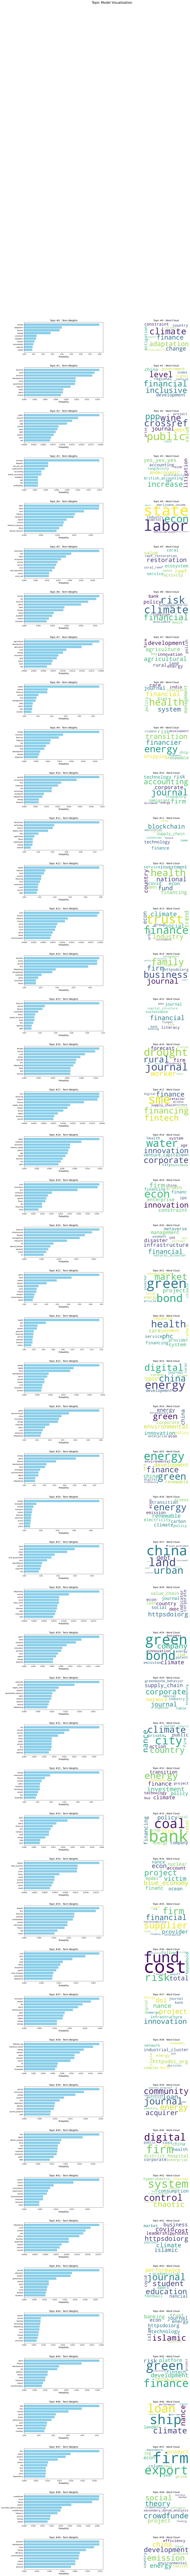

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Step 7: Enhanced Topic Visualization
def visualize_topics_enhanced(model, num_topics=50, topn=10):
    """
    Creates bar charts and word clouds for each topic
    """
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=num_topics, ncols=2, figsize=(20, 5*num_topics))

    # Adjust spacing
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    for topic_id in range(num_topics):
        # Get top terms and their probabilities
        top_terms = model.show_topic(topic_id, topn=topn)
        terms, probs = zip(*top_terms)

        # Create bar chart
        ax1 = axes[topic_id, 0]
        ax1.barh(terms, probs, color='skyblue')
        ax1.set_title(f'Topic #{topic_id} - Term Weights', fontsize=14)
        ax1.set_xlabel('Probability', fontsize=12)
        ax1.invert_yaxis()  # Show highest weight at top

        # Create word cloud
        ax2 = axes[topic_id, 1]
        word_freq = {term: prob for term, prob in top_terms}
        wordcloud = WordCloud(width=600, height=400,
                             background_color='white').generate_from_frequencies(word_freq)
        ax2.imshow(wordcloud, interpolation='bilinear')
        ax2.set_title(f'Topic #{topic_id} - Word Cloud', fontsize=14)
        ax2.axis('off')

    plt.suptitle('Topic Model Visualization', fontsize=20, y=0.99)
    plt.savefig('topic_visualization.png', bbox_inches='tight')
    plt.show()

# Train LDA model (same as before)
num_topics = 50
lda_model = LdaModel(
    corpus=filtered_corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=100,
    passes=10,
    alpha='auto'
)

# Generate enhanced visualizations
visualize_topics_enhanced(lda_model, num_topics=num_topics)

# Still include pyLDAvis for interactive exploration
try:
    import pyLDAvis.gensim_models
    vis = pyLDAvis.gensim_models.prepare(lda_model, filtered_corpus, id2word)
    pyLDAvis.display(vis)
    pyLDAvis.save_html(vis, 'interactive_topics.html')
except ImportError:
    print("pyLDAvis not installed, skipping interactive visualization")

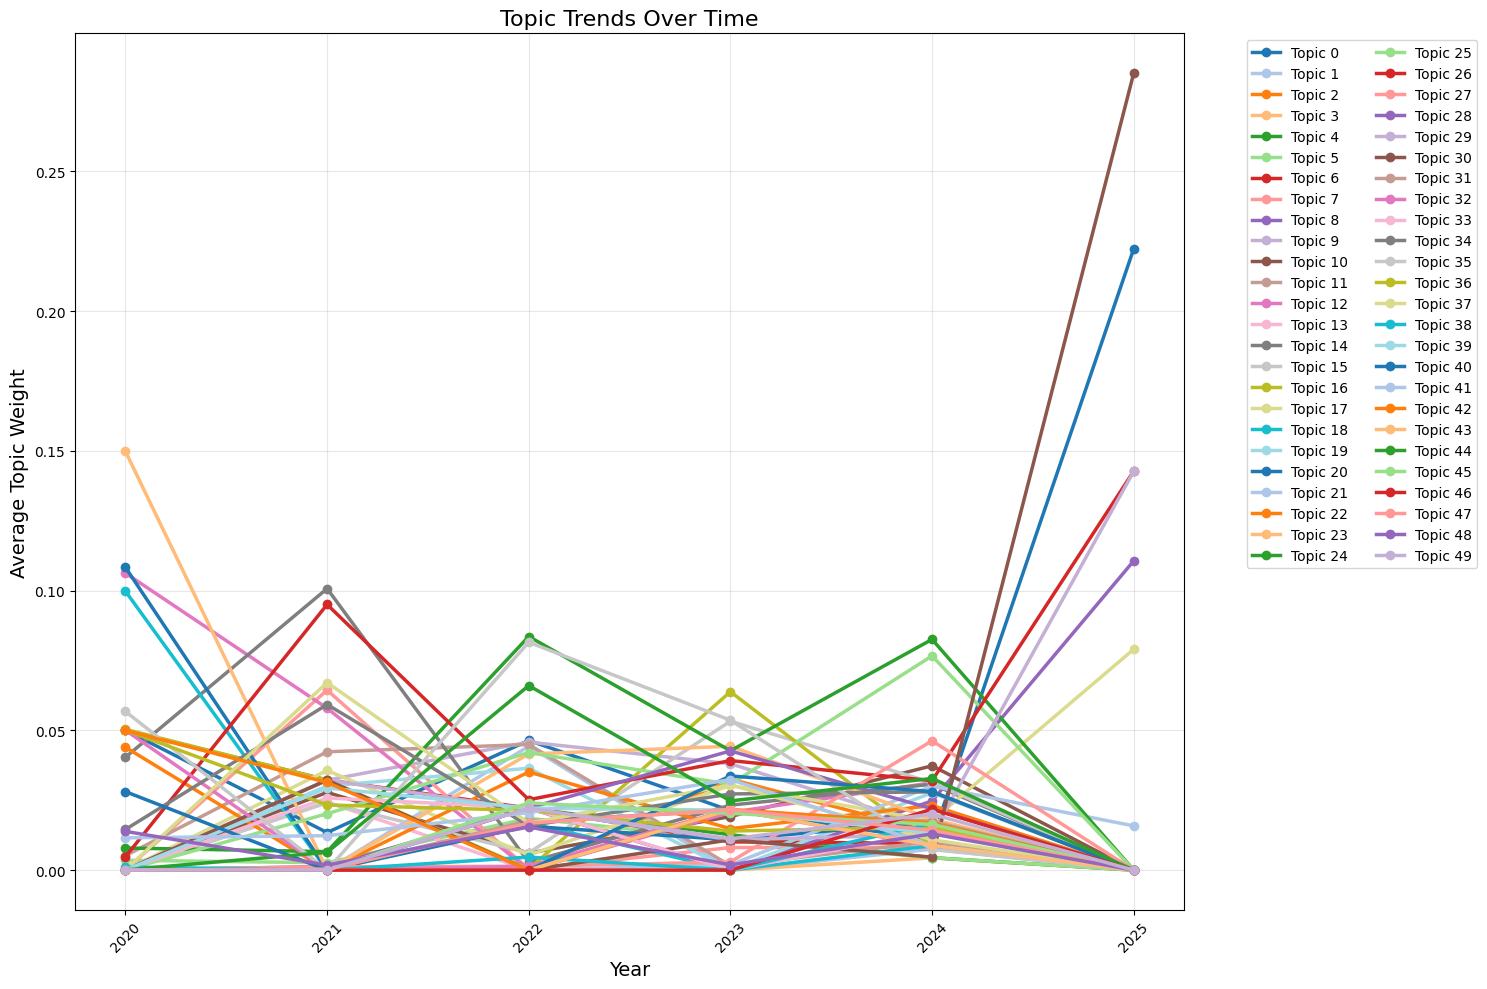

In [ ]:
# Step 8: Temporal Topic Visualization (Fixed)
def plot_topic_trends(model, doc_topic_matrix, years):
    # Get actual number of topics from the model
    num_topics = model.num_topics

    # Create topic columns based on actual model topics
    topic_cols = [f'Topic_{i}' for i in range(num_topics)]

    # Create DataFrame
    df = pd.DataFrame(doc_topic_matrix, columns=topic_cols)
    df['Year'] = years

    # Filter out unknown years
    df = df[df['Year'] != "Unknown"]

    if df.empty:
        print("No valid years found for plotting")
        return

    # Group by year and calculate mean
    yearly_topic_means = df.groupby('Year')[topic_cols].mean()

    # Plot settings
    plt.figure(figsize=(15, 10))
    colors = plt.cm.tab20.colors

    # Plot each topic trend
    for i in range(num_topics):
        plt.plot(yearly_topic_means.index,
                yearly_topic_means[f'Topic_{i}'],
                label=f'Topic {i}',
                color=colors[i % 20],
                linewidth=2.5,
                marker='o')

    # Formatting
    plt.title('Topic Trends Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Average Topic Weight', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('topic_trends.png', bbox_inches='tight')
    plt.show()

# Create doc-topic matrix using the model's actual number of topics
doc_topic_matrix = []
for doc in filtered_corpus:
    topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
    # Ensure we have probabilities for all topics
    full_dist = [0.0] * lda_model.num_topics
    for topic_id, prob in topic_dist:
        full_dist[topic_id] = prob
    doc_topic_matrix.append(full_dist)

# Generate temporal visualization
plot_topic_trends(lda_model, doc_topic_matrix, years)

In [ ]:
# Step 1: Install Gensim and verify installation
!pip install gensim==4.3.2
import importlib

# Verify installation
gensim_spec = importlib.util.find_spec("gensim")
if gensim_spec is None:
    print("Gensim installation failed! Trying alternative method...")
    !python -m pip install --no-cache-dir gensim==4.3.2

# Now import required modules
import gensim
from gensim.models import CoherenceModel
print(f"Gensim version: {gensim.__version__}")

# Step 2: Calculate Coherence Score
def calculate_coherence(model, texts, dictionary, coherence_type='c_v'):
    """
    Calculates and returns coherence score with error handling
    """
    try:
        # Check input quality
        if len(texts) == 0:
            print("Error: Empty texts list")
            return None
        if len(dictionary) == 0:
            print("Error: Empty dictionary")
            return None

        # Create and calculate coherence model
        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence=coherence_type
        )
        return coherence_model.get_coherence()
    except ValueError as e:
        print(f"ValueError: {str(e)}")
        return None
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        return None

# Step 3: Prepare inputs and calculate
# Use our preprocessed data
texts_for_coherence = ngram_data  # Tokenized documents after n-grams
dictionary = id2word  # Our created dictionary

# Calculate coherence
coherence_score = calculate_coherence(
    model=lda_model,
    texts=texts_for_coherence,
    dictionary=dictionary,
    coherence_type='c_v'
)

if coherence_score is not None:
    print(f"\nCoherence Score (C_v): {coherence_score:.4f}")

    # Interpretation
    if coherence_score > 0.6:
        print("Excellent topic coherence (≥0.6)")
    elif coherence_score > 0.5:
        print("Good topic coherence (0.5-0.6)")
    elif coherence_score > 0.4:
        print("Fair topic coherence (0.4-0.5)")
    else:
        print("Poor topic coherence (<0.4) - consider adjusting model parameters")
else:
    print("Failed to calculate coherence score")

Gensim version: 4.3.2

Coherence Score (C_v): 0.3745
Poor topic coherence (<0.4) - consider adjusting model parameters


In [ ]:
# Prepare visualization
vis = gensimvis.prepare(lda_model, filtered_corpus, id2word)

# Display in notebook
pyLDAvis.display(vis)

# Save as HTML
pyLDAvis.save_html(vis, 'lda_visualization.html')

Classify Topics by Temporal Pattern

In [ ]:
# Get distinct years from the dataset (skip "Unknown")
distinct_years = {int(year) for year in years if year and year != "Unknown"}
total_distinct_years = len(distinct_years)
min_year = min(distinct_years)
max_year = max(distinct_years)

# Calculate topic-year matrix (average weight per topic per year)
topic_year_matrix = defaultdict(lambda: defaultdict(float))
doc_topic_matrix = [lda_model.get_document_topics(doc, minimum_probability=0) for doc in filtered_corpus]

for i, doc_topics in enumerate(doc_topic_matrix):
    year = years[i]
    if year and year != "Unknown":
        for topic_id, weight in doc_topics:
            topic_year_matrix[topic_id][year] += weight

# Normalize the weights by the number of documents in each year
year_counts = defaultdict(int)
for year in years:
    if year and year != "Unknown":
        year_counts[year] += 1

for topic_id, yearly_weights in topic_year_matrix.items():
    for year, weight in yearly_weights.items():
        if year_counts[year] > 0:
            topic_year_matrix[topic_id][year] /= year_counts[year]


# Classify topics
topic_categories = {"Recurrent": [], "Emerging": [], "Seasonal": []}
for topic_id in range(lda_model.num_topics):
    # Extract years where topic's avg weight > a certain threshold (e.g., 0.05)
    # Lowering the threshold for presence even further
    presence = [
        int(year)
        for year, weight in topic_year_matrix[topic_id].items()
        if weight > 0.02  # Lowered threshold for presence
    ]
    num_years_present = len(presence)

    # Adjust classification logic
    # A topic is Recurrent if it appears in a significant percentage of all years
    # Lowering the percentage of years required for Recurrent
    if num_years_present >= total_distinct_years * 0.4:  # Appears in >= 40% of ACTUAL years
        topic_categories["Recurrent"].append(topic_id)
    elif max_year in presence and min_year not in presence:  # Recent years only
        topic_categories["Emerging"].append(topic_id)
    else:
        topic_categories["Seasonal"].append(topic_id)

print("\nTopic Classification:")
for category, topics in topic_categories.items():
    print(f"{category}: {len(topics)} topics")


Topic Classification:
Recurrent: 24 topics
Emerging: 1 topics
Seasonal: 25 topics


Visualize Topic Categories

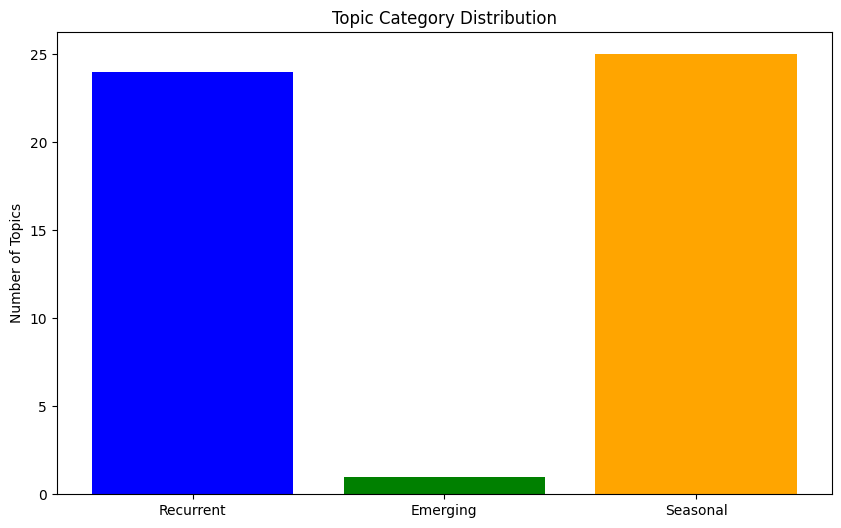


Topic Keywords by Category:

Recurrent Topics:
Topic 0: climate, adaptation, finance, change, constraint
Topic 6: climate, risk, financial, policy, bank
Topic 8: health, system, financial, journal, care
Topic 9: energy, transition, financier, shipping, risk
Topic 12: health, national, fund, country, financing
Topic 14: business, family, journal, firm, httpsdoiorg
Topic 15: financial, journal, literacy, sustainable, financ
Topic 16: drought, journal, rural, worker, forecast
Topic 17: sme, financing, fintech, finance, supply_chain
Topic 19: econ, innovation, firm, constraint, enterprise
Topic 22: health, phc, care, system, payment
Topic 23: energy, digital, china, development, nance
Topic 24: green, environmental, china, innovation, energy
Topic 25: energy, green, finance, development, china
Topic 26: energy, renewable, climate, transition, carbon
Topic 28: httpsdoiorg, country, journal, social, value_chain
Topic 29: green, bond, company, climate, innovation
Topic 34: project, blue_econ

In [ ]:
# Plot distribution
plt.figure(figsize=(10, 6))
plt.bar(topic_categories.keys(), [len(topics) for topics in topic_categories.values()], color=['blue', 'green', 'orange'])
plt.title("Topic Category Distribution")
plt.ylabel("Number of Topics")
plt.savefig('topic_categories.png')
plt.show()

# Print topic keywords
print("\nTopic Keywords by Category:")
for category, topics in topic_categories.items():
    print(f"\n{category} Topics:")
    for topic_id in topics:
        words = lda_model.show_topic(topic_id, topn=5)
        words_str = ", ".join([word for word, _ in words])
        print(f"Topic {topic_id}: {words_str}")

Topic Proportion Visualization

In [ ]:
import numpy as np
import pandas as pd

def extract_topic_proportions(lda_model, corpus, years):
    """
    Extract topic proportions for each document and aggregate by year
    Returns:
        doc_proportions: DataFrame with topic proportions for each document
        yearly_proportions: Average topic proportions by year
    """
    # Get document-topic distributions
    doc_topics = [lda_model.get_document_topics(bow, minimum_probability=0)
                  for bow in corpus]

    # Create a matrix of topic proportions
    num_topics = lda_model.num_topics
    topic_matrix = np.zeros((len(doc_topics), num_topics))

    for i, dist in enumerate(doc_topics):
        for topic, prob in dist:
            topic_matrix[i, topic] = prob

    # Create DataFrame with document-level proportions
    doc_proportions = pd.DataFrame(  # Fixed: Added closing parenthesis
        topic_matrix,
        columns=[f'Topic_{i}' for i in range(num_topics)]
    )  # Added this closing parenthesis
    doc_proportions['Year'] = years

    # Calculate yearly average proportions
    yearly_proportions = doc_proportions.groupby('Year').mean()

    return doc_proportions, yearly_proportions

In [ ]:
# Usage
doc_proportions, yearly_proportions = extract_topic_proportions(
    lda_model,
    filtered_corpus,
    years  # List of publication years for each document
)

# Example: View proportions for first 5 documents
print("Topic Proportions for First 5 Documents:")
print(doc_proportions.head(5))

# Example: View yearly proportions
print("\nYearly Average Topic Proportions:")
print(yearly_proportions)

Topic Proportions for First 5 Documents:
    Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0  0.000029  0.000023  0.000026  0.000023  0.000024  0.000026  0.000026   
1  0.000123  0.000100  0.000112  0.000098  0.000103  0.000112  0.000110   
2  0.000064  0.000052  0.000058  0.000051  0.000054  0.000059  0.000058   
3  0.000047  0.000038  0.000043  0.000037  0.000039  0.000043  0.000042   
4  0.000027  0.000022  0.000025  0.000022  0.000023  0.000025  0.000024   

    Topic_7   Topic_8   Topic_9  ...  Topic_41  Topic_42  Topic_43  Topic_44  \
0  0.000026  0.000025  0.000029  ...  0.000026  0.000026  0.000025  0.000029   
1  0.000110  0.000108  0.000125  ...  0.000112  0.000111  0.000105  0.000124   
2  0.000057  0.000056  0.000065  ...  0.000058  0.000058  0.000055  0.000065   
3  0.000042  0.000041  0.000048  ...  0.000043  0.000042  0.000040  0.000047   
4  0.000024  0.000024  0.000028  ...  0.000025  0.000024  0.000023  0.000027   

   Topic_45  Topic_46  Topi

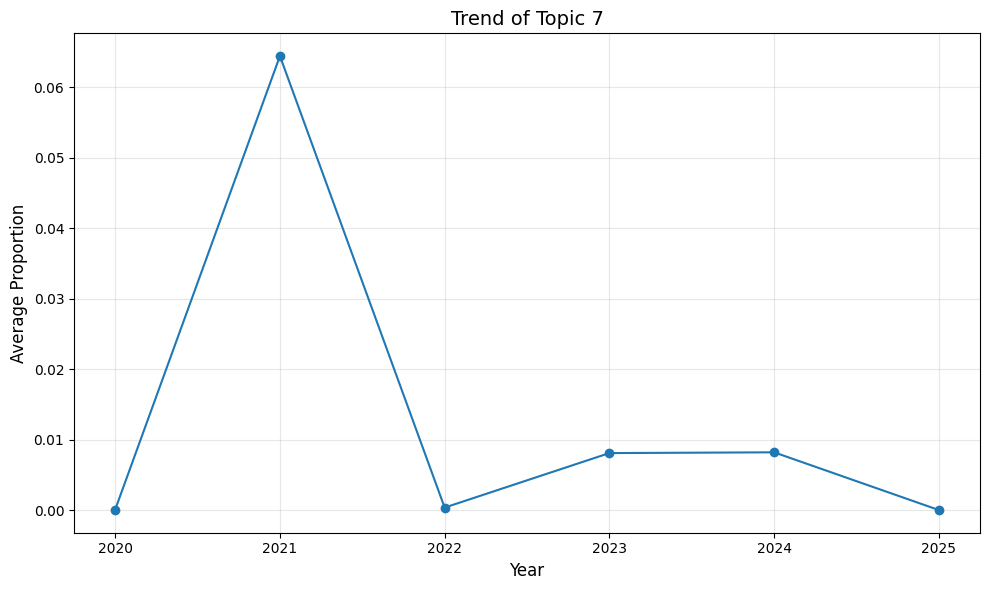

In [ ]:
import matplotlib.pyplot as plt

# Plot trend for specific topic
topic_id = 7  # Replace with topic of interest
plt.figure(figsize=(10, 6))
plt.plot(yearly_proportions.index, yearly_proportions[f'Topic_{topic_id}'],
         marker='o', linestyle='-')
plt.title(f'Trend of Topic {topic_id}', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Proportion', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'topic_{topic_id}_trend.png', dpi=300)
plt.show()

In [ ]:
# Get overall topic proportions
topic_proportions = np.zeros(num_topics)
for doc_topics in doc_topic_matrix:
    for topic_id, weight in doc_topics:
        topic_proportions[int(topic_id)] += weight

# Normalize and sort
topic_proportions /= np.sum(topic_proportions)
sorted_topics = np.argsort(topic_proportions)[::-1]

# Print top topics
print("Top 5 Dominant Topics:")
for topic_id in sorted_topics[:5]:
    print(f"Topic {topic_id}: {topic_proportions[topic_id]:.2%}")
    print("Keywords:", ', '.join([word for word, _ in lda_model.show_topic(topic_id, topn=5)]))

Top 5 Dominant Topics:
Topic 24: 6.36%
Keywords: green, environmental, china, innovation, energy
Topic 25: 5.40%
Keywords: energy, green, finance, development, china
Topic 26: 3.80%
Keywords: energy, renewable, climate, transition, carbon
Topic 14: 3.12%
Keywords: business, family, journal, firm, httpsdoiorg
Topic 23: 3.10%
Keywords: energy, digital, china, development, nance


In [ ]:
# Step 1: Install Gensim and verify installation
!pip install gensim==4.3.2
import importlib

# Verify installation
gensim_spec = importlib.util.find_spec("gensim")
if gensim_spec is None:
    print("Gensim installation failed! Trying alternative method...")
    !python -m pip install --no-cache-dir gensim==4.3.2

# Now import required modules
import gensim
from gensim.models import CoherenceModel
print(f"Gensim version: {gensim.__version__}")

# Step 2: Calculate Coherence Score
def calculate_coherence(model, texts, dictionary, coherence_type='c_v'):
    """
    Calculates and returns coherence score with error handling
    """
    try:
        # Check input quality
        if len(texts) == 0:
            print("Error: Empty texts list")
            return None
        if len(dictionary) == 0:
            print("Error: Empty dictionary")
            return None

        # Create and calculate coherence model
        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence=coherence_type
        )
        return coherence_model.get_coherence()
    except ValueError as e:
        print(f"ValueError: {str(e)}")
        return None
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        return None

# Step 3: Prepare inputs and calculate
# Use our preprocessed data
texts_for_coherence = ngram_data  # Tokenized documents after n-grams
dictionary = id2word  # Our created dictionary

# Calculate coherence
coherence_score = calculate_coherence(
    model=lda_model,
    texts=texts_for_coherence,
    dictionary=dictionary,
    coherence_type='c_v'
)

if coherence_score is not None:
    print(f"\nCoherence Score (C_v): {coherence_score:.4f}")

    # Interpretation
    if coherence_score > 0.6:
        print("Excellent topic coherence (≥0.6)")
    elif coherence_score > 0.5:
        print("Good topic coherence (0.5-0.6)")
    elif coherence_score > 0.4:
        print("Fair topic coherence (0.4-0.5)")
    else:
        print("Poor topic coherence (<0.4) - consider adjusting model parameters")
else:
    print("Failed to calculate coherence score")

Gensim version: 4.3.2

Coherence Score (C_v): 0.3745
Poor topic coherence (<0.4) - consider adjusting model parameters
